In [2]:
import ujson
import datetime as dt
import pandas as pd
import numpy as np
import pylab as pl
import seaborn as sns
import scipy.fftpack as ff

# from sklearn.gaussian_process import GaussianProcess

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [6]:
lines = []
with open("/Users/anokhin/Desktop/presents_20151x_N_1M.txt") as tlf:
    for line in tlf:
        uid, json_str = line.strip().split("\t")
        
        json = ujson.loads(json_str)
        
        count_paid = {"uid": uid, "type": "count_paid"}
        price_paid = {"uid": uid, "type": "price_paid"}        
        stdev_paid = {"uid": uid, "type": "stdev_paid"}
        
        for day, stats in json:
            date = dt.datetime.strptime(day, "%Y%m%d").date()
            
            for price_str, count in stats.iteritems():
                price = int(price_str)
                count_paid[date] = count_paid.get(date, 0) + count
                price_paid[date] = price_paid.get(date, 0) + price * count
                stdev_paid[date] = stdev_paid.get(date, 0) + price * price * count
                
        lines.append(count_paid)
        lines.append(price_paid)        
        lines.append(stdev_paid)
        
        if len(lines) > 3 * 100000:
            break
        
dates = [dt.date(2015, 1, 1) + dt.timedelta(days=i) for i in xrange(181)]
df = pd.DataFrame(lines, columns=['uid', 'type'] + dates).set_index(['uid', 'type']).fillna(0)

df.head()

2015-01-01  2015-01-02  2015-01-03  2015-01-04  \
uid            type                                                         
N:515758970872 count_paid           0           0           0           0   
               price_paid           0           0           0           0   
               stdev_paid           0           0           0           0   
N:574355141170 count_paid           0           0           0           0   
               price_paid           0           0           0           0   

                           2015-01-05  2015-01-06  2015-01-07  2015-01-08  \
uid            type                                                         
N:515758970872 count_paid           0           1           0           0   
               price_paid           0          25           0           0   
               stdev_paid           0         625           0           0   
N:574355141170 count_paid           0           2           0           0   
               price_paid           0           2           0           0   

                           2015-01-09  2015-01-10     ...      2015-06-21  \
uid            type                                   ...                   
N:515758970872 count_paid           0           1     ...               0   
               price_paid           0           1     ...               0   
               stdev_paid           0           1     ...               0   
N:574355141170 count_paid           0           0     ...               1   
               price_paid           0           0     ...               1   

                           2015-06-22  2015-06-23  2015-06-24  2015-06-25  \
uid            type                                                         
N:515758970872 count_paid           0           0           0           0   
               price_paid           0           0           0           0   
               stdev_paid           0           0           0           0   
N:574355141170 count_paid           0           0           0           0   
               price_paid           0           0           0           0   

                           2015-06-26  2015-06-27  2015-06-28  2015-06-29  \
uid            type                                                         
N:515758970872 count_paid           1           0           0           0   
               price_paid          35           0           0           0   
               stdev_paid        1225           0           0           0   
N:574355141170 count_paid           0           0           0           0   
               price_paid           0           0           0           0   

                           2015-06-30  
uid            type                    
N:515758970872 count_paid           0  
               price_paid           0  
               stdev_paid           0  
N:574355141170 count_paid           0  
               price_paid           0  

[5 rows x 181 columns]

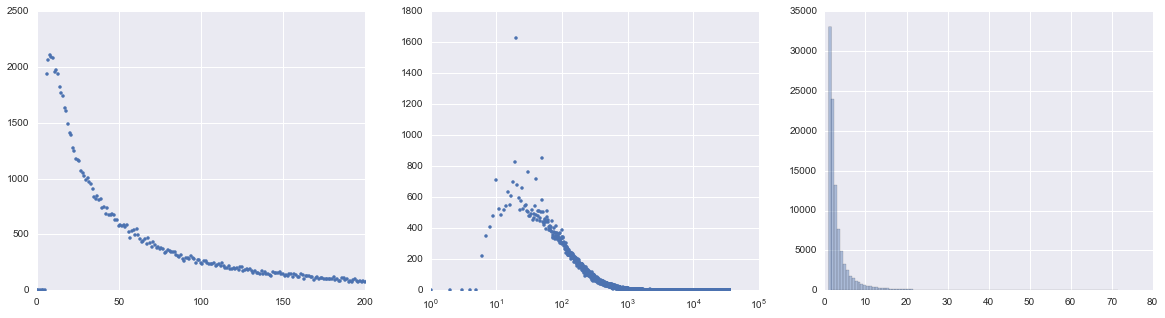

In [28]:
n_paid = df.swaplevel(0, 1, axis=0).ix["count_paid"].sum(axis=1)
p_paid = df.swaplevel(0, 1, axis=0).ix["price_paid"].sum(axis=1)
m_paid = p_paid / n_paid

pl.figure(figsize=(20, 5))

ax = pl.subplot(1, 3, 1)
pl.plot(np.arange(max(n_paid) + 1), np.bincount(n_paid.values.astype(int)), '.')
pl.xlim(0, 200)

ax = pl.subplot(1, 3, 2)
pl.plot(np.arange(max(p_paid) + 1), np.bincount(p_paid.values.astype(int)), '.')
# pl.xlim(0, 1000)
ax.set_xscale('log')

ax = pl.subplot(1, 3, 3)
sns.distplot(m_paid, bins=100, kde=False)
# ax.set_xscale('log')

pl.show()

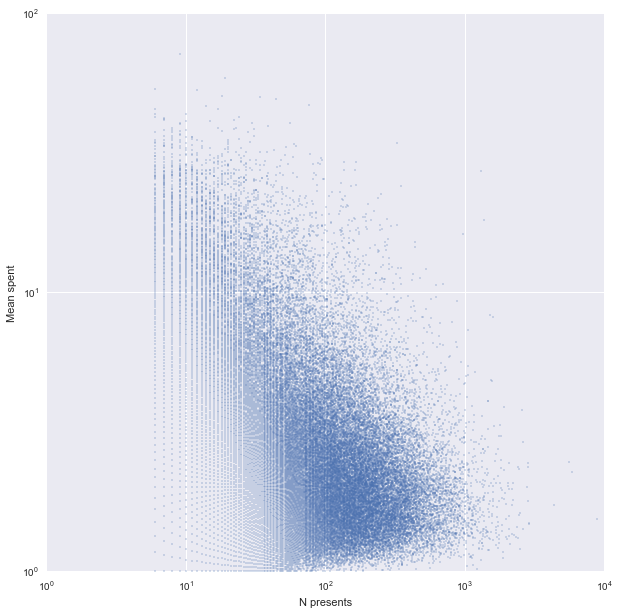

In [74]:
counts = pd.DataFrame([n_paid, m_paid]).T.groupby([0, 1]).size()

pl.figure(figsize=(10, 10))
cm = pl.get_cmap('gist_rainbow')
pl.plot(counts.index.levels[0][counts.index.labels[0]], counts.index.levels[1][counts.index.labels[1]], '.', markersize=3, alpha=0.5)
pl.xlabel('N presents')
pl.ylabel('Mean spent')
pl.gca().set_xscale('log')
pl.gca().set_yscale('log')
pl.show()

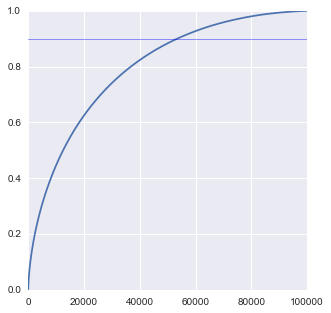

In [24]:
p_paid = df.swaplevel(0, 1, axis=0).ix["price_paid"].sum(axis=1)

pl.figure(figsize=(5, 5))
pl.plot(np.arange(p_paid.shape[0]), np.cumsum(p_paid.sort_values(ascending=False)) / np.sum(p_paid))
pl.axhline(0.9, color='blue', lw=1, alpha=0.4)
pl.show()

In [27]:
def make_group(n, df):
    group = df[:n].groupby(level='type').sum()
    count = group.ix["count_paid"].values + 1e-6
    price = 1.0 * group.ix["price_paid"].values / count
    stdev = np.sqrt(1.0 * group.ix["stdev_paid"].values / count - price * price)
    return count, price, stdev

In [25]:
def plot_timeline(group, dates, color='r', shift=0):
    X = np.atleast_2d([int(d.strftime('%j')) for d in dates]).T
    n, y, dy = group
    pl.plot(X + shift, y[-len(dates):], 'o' + color, markersize=5, alpha=0.5)
    pl.errorbar(X.ravel() + shift, y[-len(dates):], dy[-len(dates):], fmt=color + '.', markersize=5, alpha=0.1)
    pl.xlim(X.min() - 1, X.max() + 1)
    pl.ylim(0, (y + dy).max()*1.1)

def plot_timeline_smooth(group, dates, color='r', shift=0):
    x = np.array([int(d.strftime('%j')) for d in dates])
    n, y, dy = group
    
    from scipy.interpolate import spline
    x_new = np.linspace(x.min(),x.max(),10000)    
    y_new = spline(x, y.flatten()[-len(dates):], x_new)
    
    pl.plot(x_new + shift, y_new, '-' + color, markersize=5, alpha=0.5)    
    pl.plot(x + shift, y[-len(dates):], 'o' + color, markersize=5, alpha=0.5)
    pl.ylim(0, (y + dy).max()*1.1)

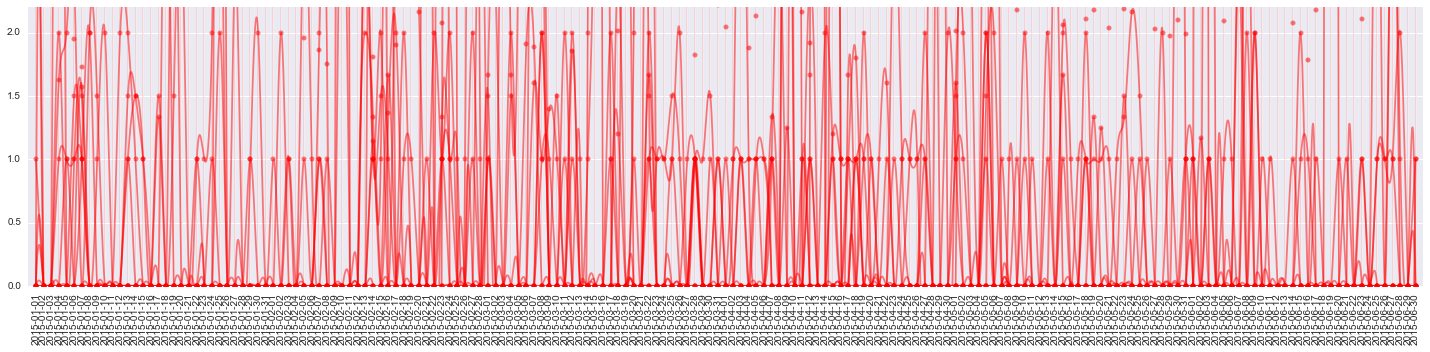

In [26]:
fig = pl.figure(figsize=(25, 5))

# pl.subplot(1, 1, 1)
plot_timeline(make_group(30000, df), dates, 'r')
n = 0
for uid, part in df.groupby(level='uid'):    
    plot_timeline_smooth(make_group(3, part), dates, 'r')    
    n += 1
    if n == 10:
        break

pl.xticks([int(d.strftime('%j')) for d in dates], [d for i, d in enumerate(dates) if i % 1 == 0], rotation='vertical')

pl.show()

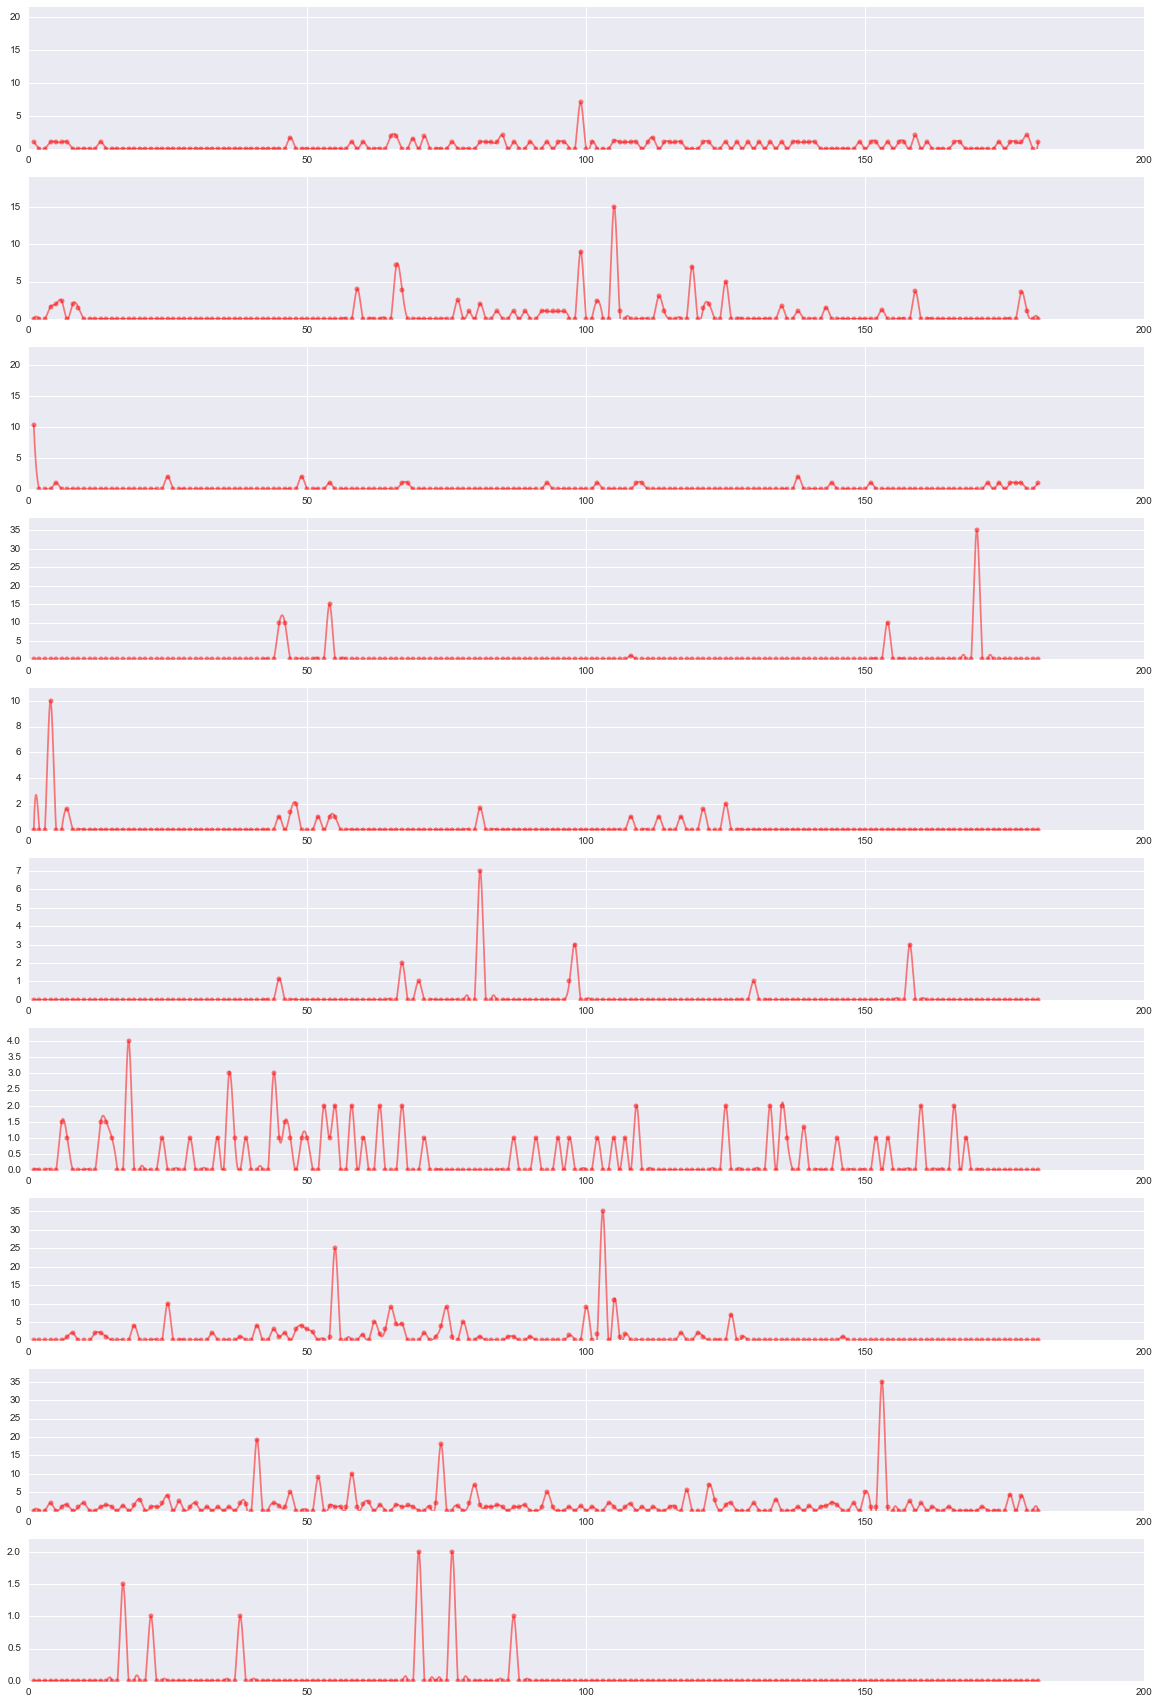

In [16]:
n = 0
N = 10
pl.figure(figsize=(20, 3 * N))
for uid, part in df.groupby(level='uid'):
    n += 1
    group = make_group(3, part)
    pl.subplot(N, 1, n)
    plot_timeline_smooth(group, dates, 'r')    
    if n >= N:
        break
pl.show()

## Целевая переменная для отбора фич

In [4]:
total_price = df.swaplevel(0, 1, axis=0).ix["price_paid"].sum(axis=1)
total_count = df.swaplevel(0, 1, axis=0).ix["count_paid"].sum(axis=1)
means = total_price / total_count
means.sort_values(ascending=False)

target_df = pd.DataFrame({'price': total_price, 'mean': means})
target_df.to_csv('/Users/anokhin/Desktop/target.txt')

## Результат кластеризации

In [94]:
clust_df = pd.read_csv('/Users/anokhin/Desktop/clust.txt', header=None, names=['uid', 'cluster']).set_index('uid')
clust_df

,cluster
uid,
H:537439349485,0
H:491150380365,3
H:342296609187,4
H:557545266688,3
H:466687278828,4
H:518436520164,6
H:454920883235,0
H:517663002738,0
H:358970128144,4


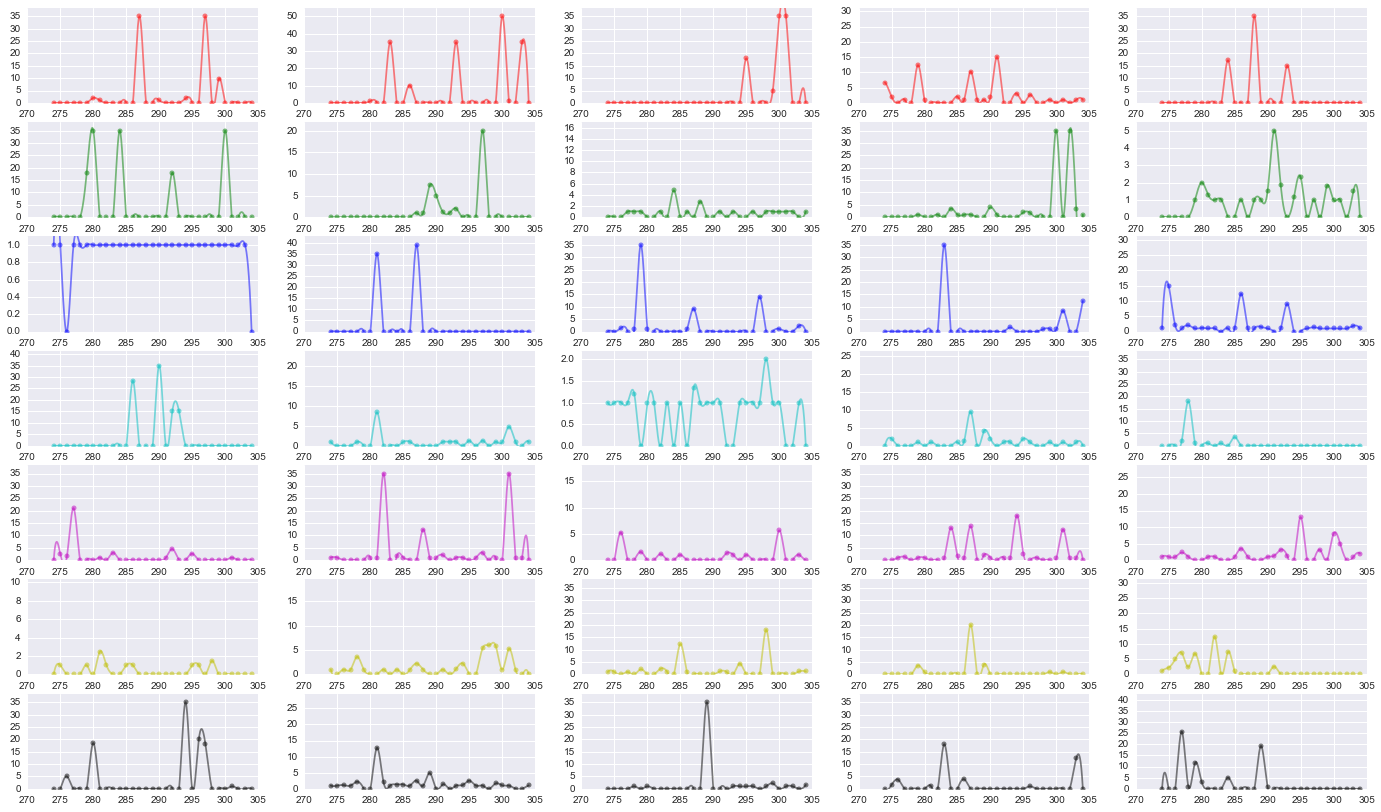

In [95]:
K = 5
Ncl = len(np.unique(clust_df["cluster"]))

pl.figure(figsize=(24, Ncl * 2))
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'r']

for k in xrange(Ncl):
    cluster = clust_df[clust_df["cluster"] == k].sample(K)
    for i, (uid, row) in enumerate(cluster.iterrows()):        
        pl.subplot(len(np.unique(clust_df["cluster"])), K, K*k + i + 1)
        plot_timeline_smooth(make_group(3, df.ix[uid]), dates, colors[row["cluster"]])
        
pl.show()

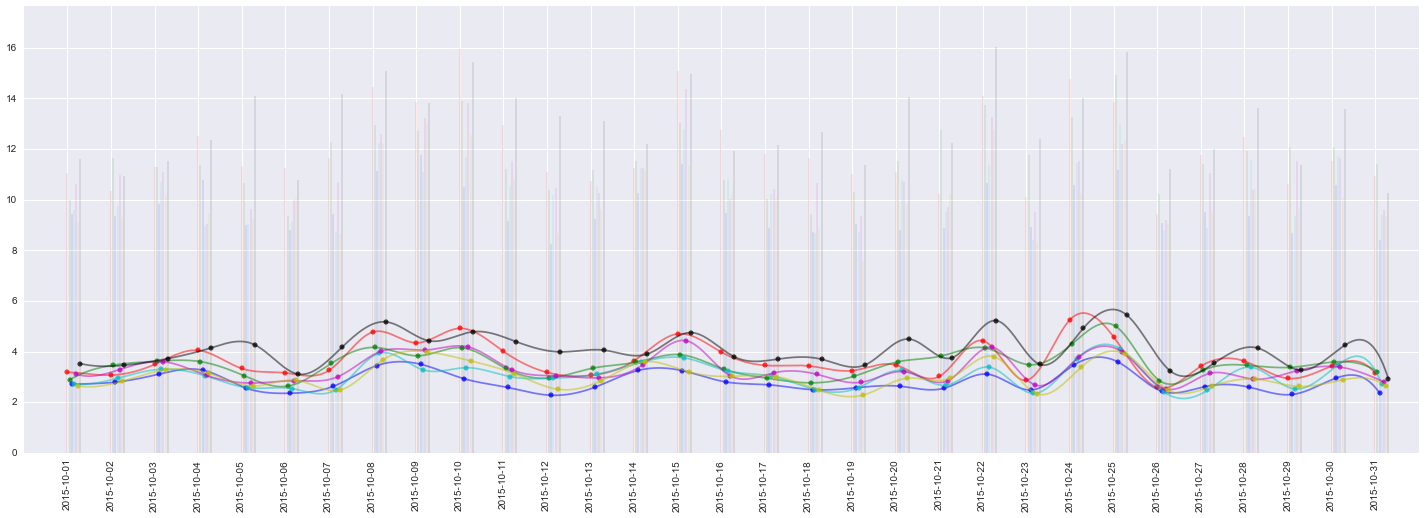

In [99]:
clm_df = pd.merge(clust_df, df, how='inner', right_index=True, left_index=True)
# make_group(3, clm_df[clm_df["cluster"] == 1])

colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'r']
fig = pl.figure(figsize=(25, 8))

for k in xrange(Ncl):    
    plot_timeline(make_group(3000, clm_df[clm_df["cluster"] == k]), dates, colors[k], 0.05 * k)
    plot_timeline_smooth(make_group(3000, clm_df[clm_df["cluster"] == k]), dates, colors[k], 0.05 * k)
    
pl.xticks([int(d.strftime('%j')) for d in dates], [d for i, d in enumerate(dates) if i % 1 == 0], rotation='vertical')
pl.show()